# 데이터 셋 만들기

In [1]:
from IPython.display import display
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import random

import torchvision.transforms as transforms

import os

from matplotlib.pyplot import imshow

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import matplotlib.image as img
from sklearn.model_selection import train_test_split

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)
random.seed(0)


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
# !pip install -q wandb
# import wandb
# wandb.login()

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
class CustomDataset(Dataset):
  def __init__(self, imgs, malices, names):
        super().__init__()
        self.imgs = imgs
        self.malices = malices
        self.names = names
        
  def __len__(self):
      return len(self.imgs)
  
  def __getitem__(self,index):
      return self.imgs[index], self.malices[index], self.names[index]

In [5]:
from zipfile import ZipFile
from PIL import Image
import zipfile
import cv2
import numpy as np
import random

def convertPILImageToCV2(pil_image):
  np_image = np.array(pil_image)
  open_cv_image = np.array(pil_image) 

  open_cv_image = open_cv_image[:, :, ::-1].copy() 

  return open_cv_image

benign_path = '/content/drive/MyDrive/Malware Analysis/kisa_dataset/benign_image.zip'
malign_path = '/content/drive/MyDrive/Malware Analysis/kisa_dataset/malign_image.zip'
benign_zip = ZipFile(benign_path,'r')
malign_zip = ZipFile(malign_path,'r')

#benign
benign_info_list = benign_zip.infolist()
benign_name_list = benign_zip.namelist()
malign_info_list = malign_zip.infolist()
malign_name_list = malign_zip.namelist()

benign_set = []
malign_set = []



for i in range(len(benign_info_list)):
  _file = benign_zip.open(benign_info_list[i])
  img = Image.open(_file)
  img = convertPILImageToCV2(img)
  name = benign_name_list[i]
  benign_set.append((img, 0, name))
  

for i in range(len(malign_info_list)):
  _file = malign_zip.open(malign_info_list[i])
  img = Image.open(_file)
  img = convertPILImageToCV2(img)
  name = malign_name_list[i]
  malign_set.append((img, 1, name))
  


num_each_test = 400

raw_test_set = benign_set[:num_each_test] + malign_set[:num_each_test]
random.shuffle(raw_test_set)
raw_train_set = benign_set[num_each_test:] + malign_set[num_each_test:]
random.shuffle(raw_train_set)


In [6]:
# benign_zip.namelist()

## Normalizing

In [7]:
train_meanRGB = [np.mean(x, axis=(1,2)) for x,_, __ in raw_train_set]
train_stdRGB = [np.std(x, axis=(1,2)) for x,_, __ in raw_train_set]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])

train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

test_meanRGB = [np.mean(x, axis=(1,2)) for x,_, __ in raw_test_set]
test_stdRGB = [np.std(x, axis=(1,2)) for x,_, __ in raw_test_set]

test_meanR = np.mean([m[0] for m in test_meanRGB])
test_meanG = np.mean([m[1] for m in test_meanRGB])
test_meanB = np.mean([m[2] for m in test_meanRGB])

test_stdR = np.mean([s[0] for s in test_stdRGB])
test_stdG = np.mean([s[1] for s in test_stdRGB])
test_stdB = np.mean([s[2] for s in test_stdRGB])



normalized_zero_r = (0-test_meanR)/test_stdR
print(normalized_zero_r)


-0.10260687918659961


In [8]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([train_meanR,train_meanG,train_meanB],[train_stdR, train_stdG, train_stdB])
                                      ])
test_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(),
                                     transforms.Normalize([test_meanR, test_meanG, test_meanB],[test_stdR, test_stdG, test_stdB])
                                      ])

train_imgs, train_malices, train_names = [],[], []
test_imgs, test_malices, test_names = [],[],[]


for img,mal,name in raw_train_set:
  train_imgs.append(train_transform(img))
  train_malices.append(mal)
  train_names.append(name)
for img,mal,name in raw_test_set:
  test_imgs.append(test_transform(img))
  test_malices.append(mal)
  test_names.append(name)


train_set = CustomDataset(train_imgs, train_malices, train_names)
test_set = CustomDataset(test_imgs, test_malices, test_names)

# 모델 정의

In [9]:
# hyperparameter_defaults = dict(
#     dataset = "MALWARE",
#     gpu = "colab",
#     dropout = 0.4,
#     dropout2 = 0.4,
#     layer_1_out_channels = 10,
#     layer_2_out_channels = 20,
#     layer_3_out_features = 300,
#     layer_4_out_features = 150,
#     batch_size = 256,
#     learning_rate = 0.001,
#     weight_decay = 1e-5,
#     kernel_size = 5,
#     )

# wandb.init(config=hyperparameter_defaults, project="Malware_analysis")
# config = wandb.config

In [10]:
# sweep_config = {
#   "name" : "seed_fixed_max_f1_acc_sweep_128_original",
#   "method" : "random",
#   "metric" : {
#       "goal" : "minimize",
#       "name" : "valid_loss"
#   },
#   "parameters" : {
#     "dropout" : {
#       "values" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
#     },
#     "dropout2" : {
#       "values" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
#     },
#     "layer_1_out_channels" : {
#         "distribution" : "int_uniform",
#         "min" : 10,
#         "max" : 30,
#     },
#     "layer_2_out_channels" : {
#         "distribution" : "int_uniform",
#         "min" : 20,
#         "max" : 40,
#     },
#     "layer_3_out_features" : {
#         "distribution" : "int_uniform",
#         "min" : 300,
#         "max" : 500,
#     },
#     "layer_4_out_features" : {
#         "distribution" : "int_uniform",
#         "min" : 100,
#         "max" : 300,
#     },
#     "learning_rate" : {
#         "distribution" : "log_uniform_values",
#         "min": 1e-4,
#         "max": 1e-1,
#     },
#     "weight_decay" : {
#         "distribution" : "log_uniform_values",
#         "min": 1e-4,
#         "max": 1e-1,
#     }
#   },
#   "early_terminate": {
#       "type": "hyperband",
#       "eta" : 3,
#       "min_iter" : 3,
#   }
# }

# sweep_id = wandb.sweep(sweep_config, project="Malware_analysis")

In [11]:
from torchvision import models

train_losses = []
valid_losses = []

num_epochs = 100
batch_size = 64
learning_rate = 0.0005387
weight_decay = 0.01594

train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle=False, num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = CNN().to(device)
model = models.resnet50(pretrained=False)
# model = models.resnet
num_classes = 2
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate, weight_decay=weight_decay)

print(device)
print(model)


cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride

# Training 

In [12]:
# torch.cuda.empty_cache()

In [ ]:
# keeping-track-of-losses 
# %%time 
import time

  # 현재시각 - 시작시간 = 실행 시간
for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    
    start = time.time()
    for data, target,_ in train_loader:
        
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    correct = 0
    total = 0
        
    for data, target,_ in test_loader:
        
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
              
        loss = criterion(output, target)
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(test_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    print("time :", time.time() - start)
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

    # # test-the-model
    # with torch.no_grad():
    #     correct = 0
    #     total = 0
    #     for images, labels,_ in test_loader:
    #         images = images.to(device)
    #         labels = labels.to(device)
    #         outputs = model(images)
    #         _, predicted = torch.max(outputs.data, 1)
    #         total += labels.size(0)
    #         correct += (predicted == labels).sum().item()
              
    #     print('Test Accuracy of the model: {} %'.format(100 * correct / total))

Epoch: 1 	Training Loss: 0.653599 	Validation Loss: 1.586495
time : 8.362780094146729
Test Accuracy of the model: 47.625 %
Epoch: 2 	Training Loss: 0.422765 	Validation Loss: 0.597230
time : 7.60979151725769
Test Accuracy of the model: 68.125 %
Epoch: 3 	Training Loss: 0.338360 	Validation Loss: 0.718743
time : 7.583219528198242
Test Accuracy of the model: 60.875 %
Epoch: 4 	Training Loss: 0.301512 	Validation Loss: 0.542640
time : 7.57535982131958
Test Accuracy of the model: 71.625 %
Epoch: 5 	Training Loss: 0.281379 	Validation Loss: 0.449034
time : 7.62598180770874
Test Accuracy of the model: 77.625 %
Epoch: 6 	Training Loss: 0.266933 	Validation Loss: 0.523901
time : 7.64725399017334
Test Accuracy of the model: 77.0 %
Epoch: 7 	Training Loss: 0.272647 	Validation Loss: 0.532144
time : 7.6009345054626465
Test Accuracy of the model: 77.5 %
Epoch: 8 	Training Loss: 0.262143 	Validation Loss: 0.686863
time : 7.639746904373169
Test Accuracy of the model: 63.375 %
Epoch: 9 	Training Loss

# Testing

In [ ]:
# test-the-model
model.eval()  # it-disables-dropout
predict = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels,_ in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predict.extend(predicted.detach().cpu())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 80.625 %


In [ ]:
#predict
test_loader

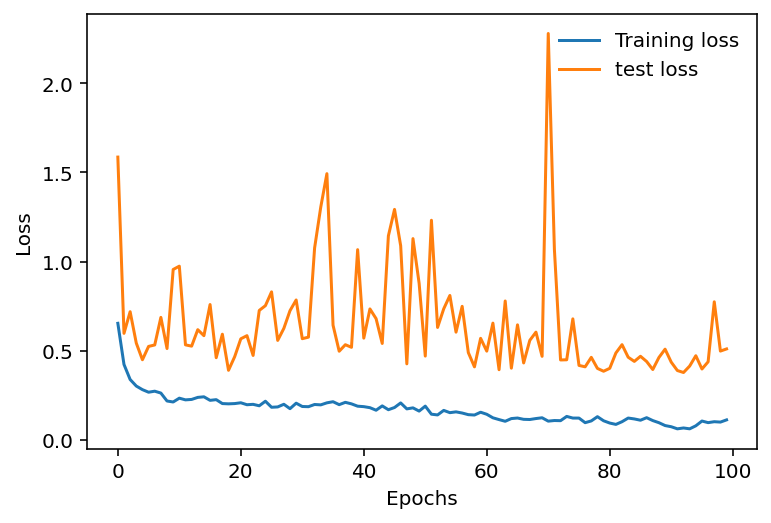

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='test loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
t = confusion_matrix(test_set.malices, predict)
f1 = f1_score(test_set.malices, predict)
print(f1)
print(t)

np_predict = np.array(predict)
np_malices = np.array(test_set.malices)


t = np_predict == np_malices # T : 정답이 맞는 경우 
f = np_predict != np_malices # F : 정답에 틀린 경우

# 각 그룹의 베이직 블록 개수, 픽셀 개수, (베이직 블록 - 픽셀 개수), 그룹당 평균, 중간
index_true = np.where(t)[0]
index_false = np.where(f)[0]
benign_block_dir = '/content/drive/MyDrive/Malware Analysis/kisa_dataset/benign_block/'
malign_block_dir = '/content/drive/MyDrive/Malware Analysis/kisa_dataset/malign_block/'

0.8187134502923977
[[295 105]
 [ 50 350]]


In [ ]:
import torch
import math


E = 0.0000001

def truncate(num, n):
    integer = int(num * (10**n))/(10**n)
    return float(integer)

def get_num_pixel(tensor_r, normalized_zero_r):
  pixels = (tensor_r.numpy() - normalized_zero_r) > E 
  cnt = np.count_nonzero(pixels)
  return cnt

true_benign_basic_block_nums = []
true_malign_basic_block_nums = []
true_benign_pixel_nums = []
true_malign_pixel_nums = []

false_benign_basic_block_nums = []
false_malign_basic_block_nums = []
false_benign_pixel_nums = []
false_malign_pixel_nums = []

normalized_zero_r = (0-test_meanR)/test_stdR
normalized_zero_r = truncate(normalized_zero_r,8)

demo = 400 # 최대 400까지 

for idx in index_true[:demo]:
  tensor, malice, name = test_set[idx]
  name = name.replace('.png','.txt')
  path = benign_block_dir+name if malice == 0 else malign_block_dir+name
  # 베이직 블록 개수 세기 위해, 파일을 엽니다. 
  block_file = open(path,'r')
  num_block = len(block_file.readlines())
  num_pixels = get_num_pixel(tensor[0], normalized_zero_r)
  
  # 베이직 블록 개수, 픽셀 개수를 입력합니다. 
  if malice == 0:
    true_benign_basic_block_nums.append(num_block)
    true_benign_pixel_nums.append(num_pixels)
    
  else: 
    true_malign_basic_block_nums.append(num_block)
    true_malign_pixel_nums.append(num_pixels)

print()
for idx in index_false[:demo]:
  tensor, malice, name = test_set[idx]
  name = name.replace('.png','.txt')
  path = benign_block_dir+name if malice == 0 else malign_block_dir+name
  # 베이직 블록 개수 세기 위해, 파일을 엽니다. 
  block_file = open(path,'r')
  num_block = len(block_file.readlines())
  num_pixels = get_num_pixel(tensor[0], normalized_zero_r)
  
  # 베이직 블록 개수, 픽셀 개수를 입력합니다. 
  if malice == 0:
    false_benign_basic_block_nums.append(num_block)
    false_benign_pixel_nums.append(num_pixels)
  else: 
    false_malign_basic_block_nums.append(num_block)
    false_malign_pixel_nums.append(num_pixels)

  

In [ ]:
print(f1)

0.8187134502923977


In [ ]:
# True_benign
# True_malign
# False_benign
# False_malign
def stat(block_nums, pixel_nums, label):
  min_block = min(block_nums)
  mean_block = np.mean(block_nums)
  min_pixels = min(pixel_nums)
  mean_pixels = np.mean(pixel_nums)
  diff = np.array(block_nums) - np.array(pixel_nums)
  min_diff = min(diff)
  mean_diff = np.mean(diff)
  median_block = np.median(block_nums)
  median_pixels = np.median(pixel_nums)
  print(f'====={label}=====')
  print(f'블록 개수 평균 : {mean_block}, 픽셀 개수 평균 : {mean_pixels}, 평균 차이 : {mean_diff} 정보 손실률: {100 - (mean_pixels/mean_block) * 100}%')
  print(f'중간값 블록 : {median_block}, 중간값 픽셀 : {median_pixels}')

stat(true_benign_basic_block_nums, true_benign_pixel_nums, "True benign")
stat(true_malign_basic_block_nums, true_malign_pixel_nums, 'True malign')
stat(false_benign_basic_block_nums, false_benign_pixel_nums, 'False benign')
stat(false_malign_basic_block_nums, false_malign_pixel_nums, 'False malign')

=====True benign=====
블록 개수 평균 : 2070.621052631579, 픽셀 개수 평균 : 893.2473684210527, 평균 차이 : 1177.3736842105263 정보 손실률: 56.86089604441078%
중간값 블록 : 1100.5, 중간값 픽셀 : 632.5
=====True malign=====
블록 개수 평균 : 1613.4380952380952, 픽셀 개수 평균 : 547.5380952380953, 평균 차이 : 1065.9 정보 손실률: 66.06389195506785%
중간값 블록 : 300.5, 중간값 픽셀 : 210.0
=====False benign=====
블록 개수 평균 : 1880.8666666666666, 픽셀 개수 평균 : 724.3333333333334, 평균 차이 : 1156.5333333333333 정보 손실률: 61.48938432637436%
중간값 블록 : 937.0, 중간값 픽셀 : 544.0
=====False malign=====
블록 개수 평균 : 883.3, 픽셀 개수 평균 : 449.9, 평균 차이 : 433.4 정보 손실률: 49.06600249066002%
중간값 블록 : 418.0, 중간값 픽셀 : 222.0


In [ ]:
# 잘 구분되는 benign, malign


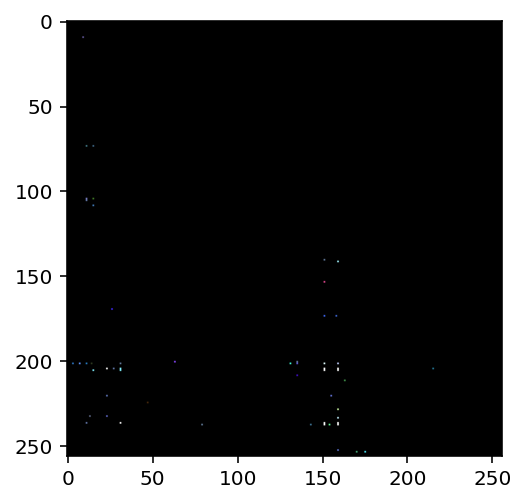

ang


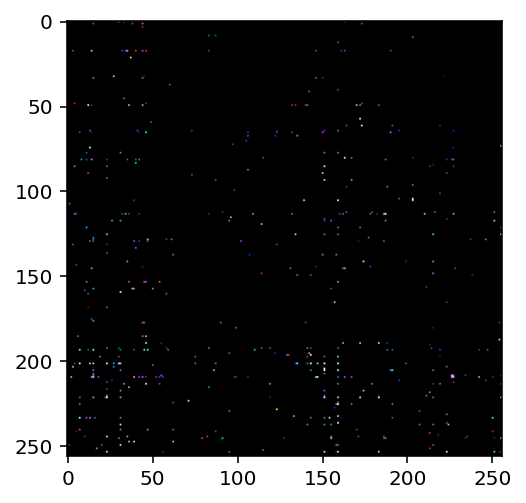

ang


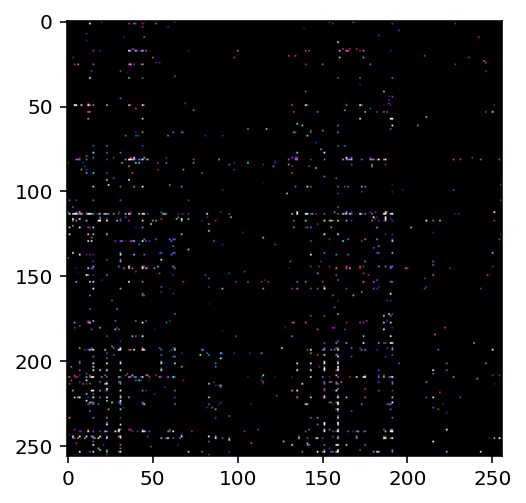

ang


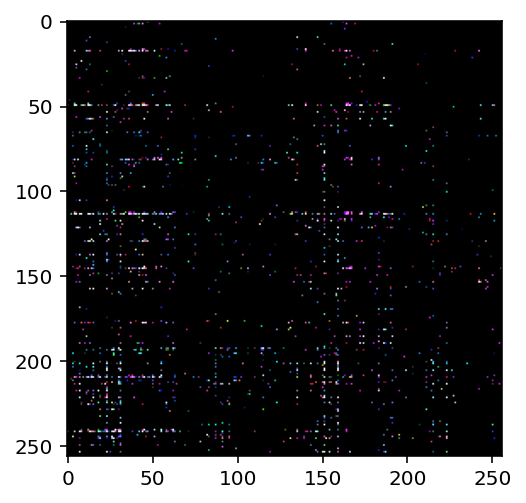

ang


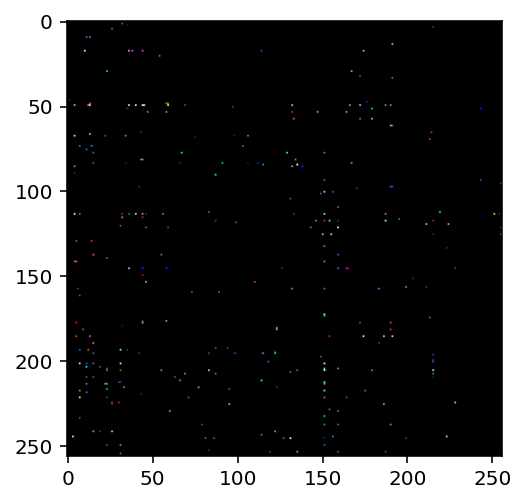

ang


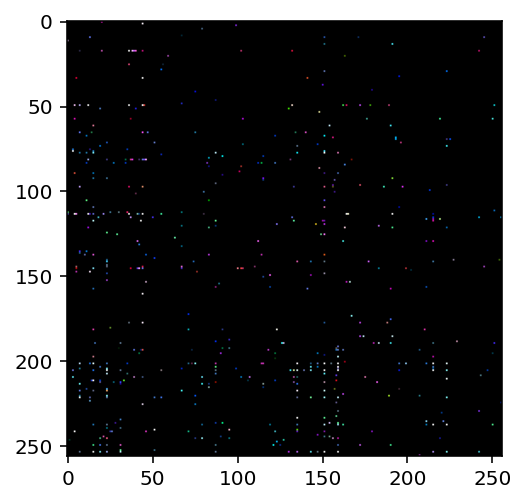

ang


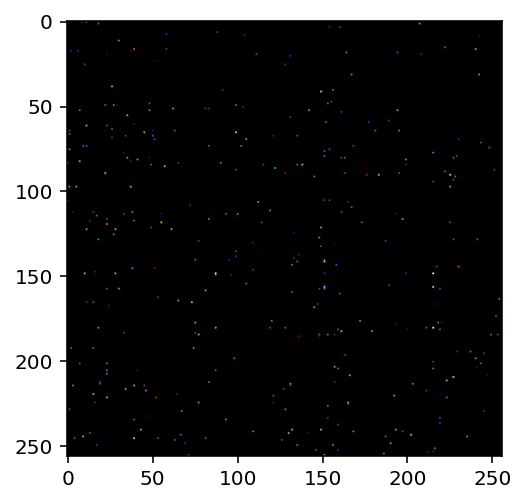

ang


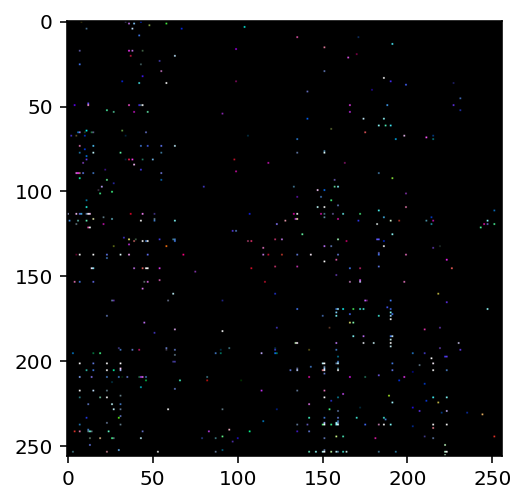

ang


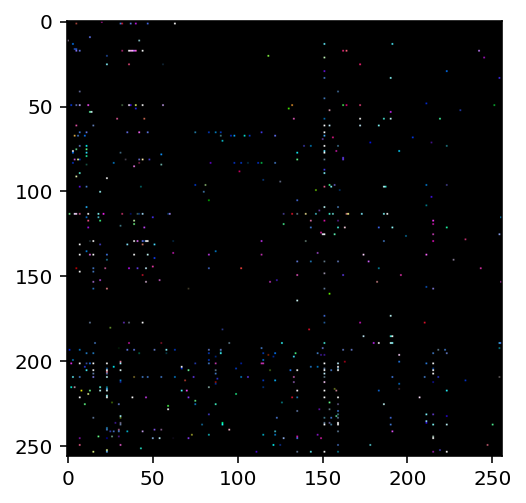

ang


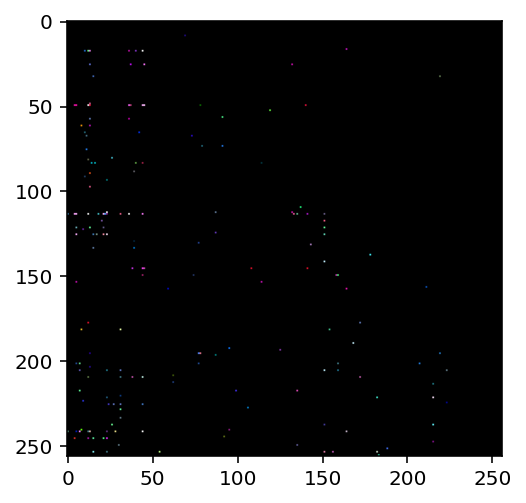

ang


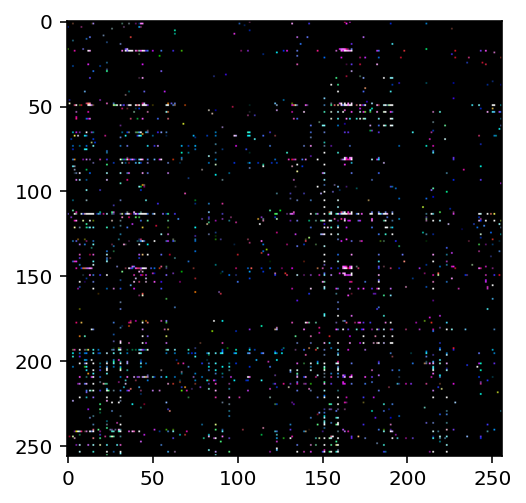

ang


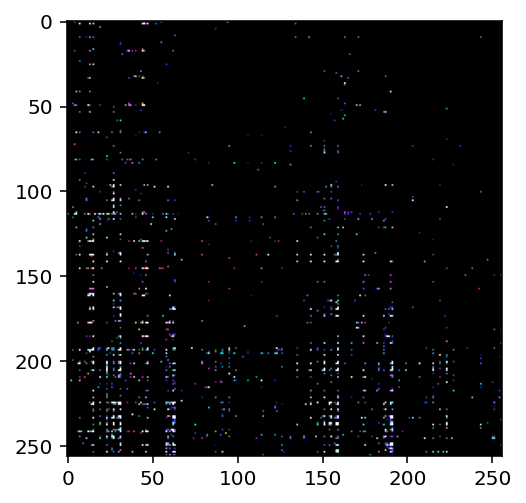

ang


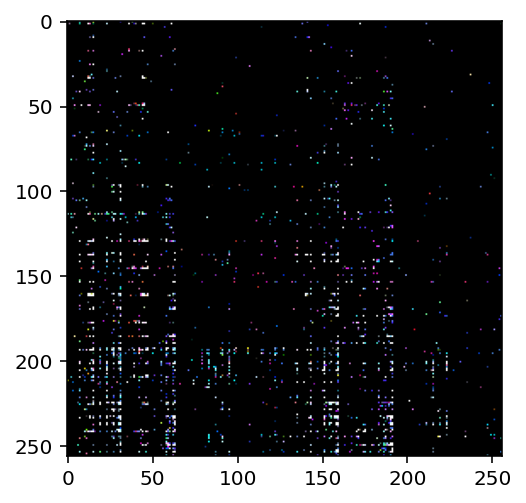

ang


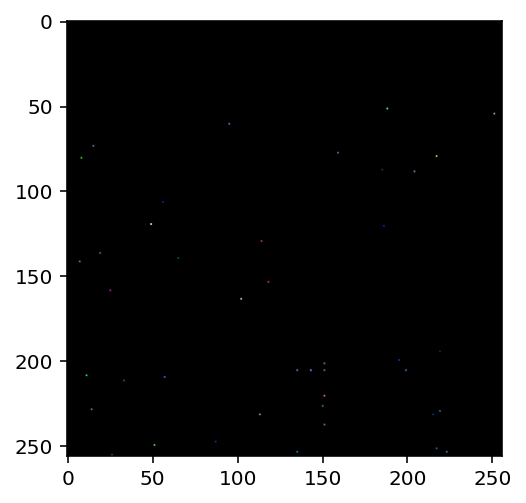

ang


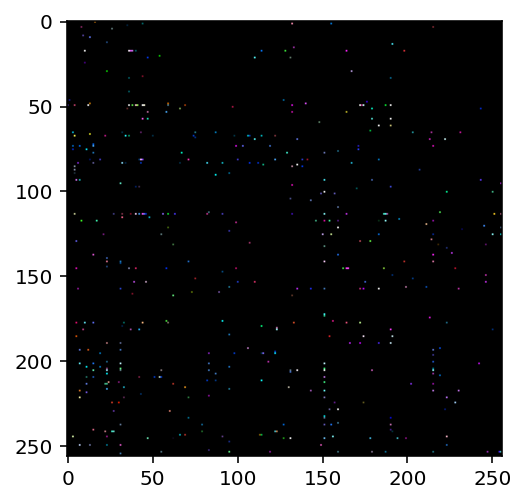

ang


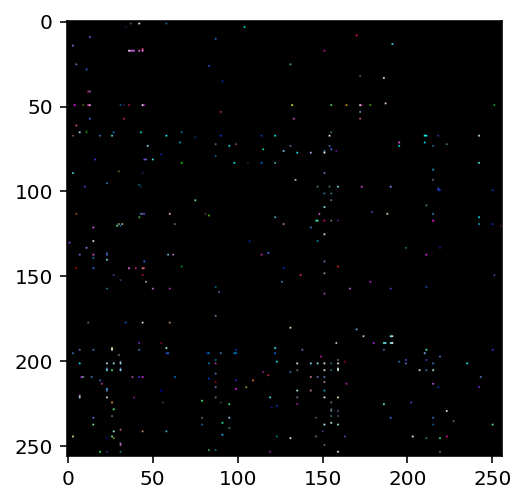

ang


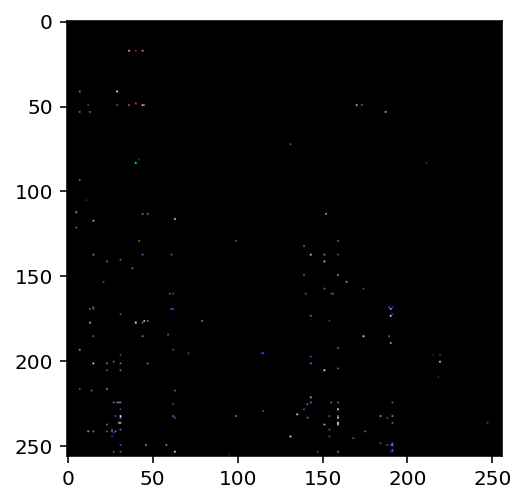

ang


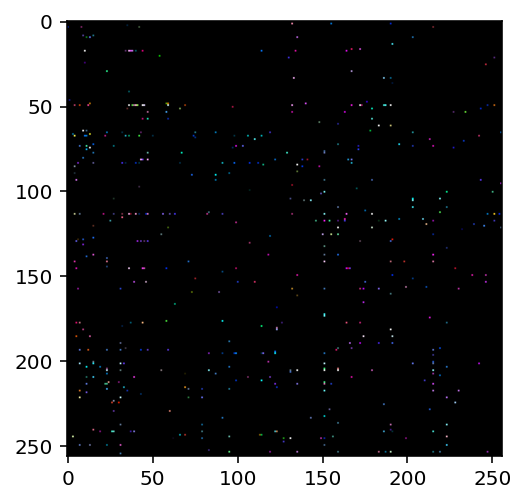

ang


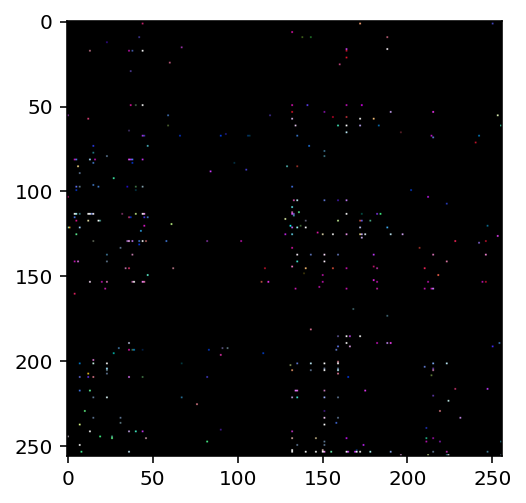

ang


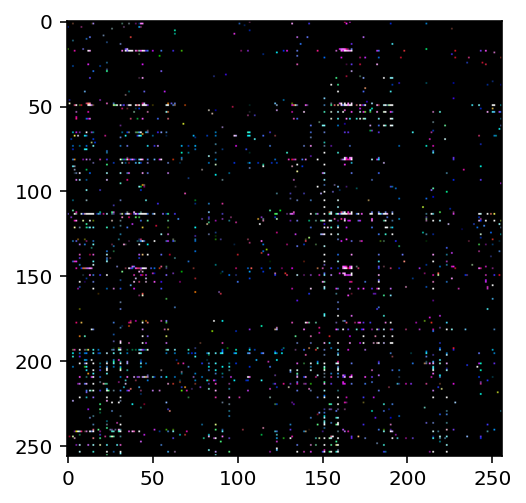

ang


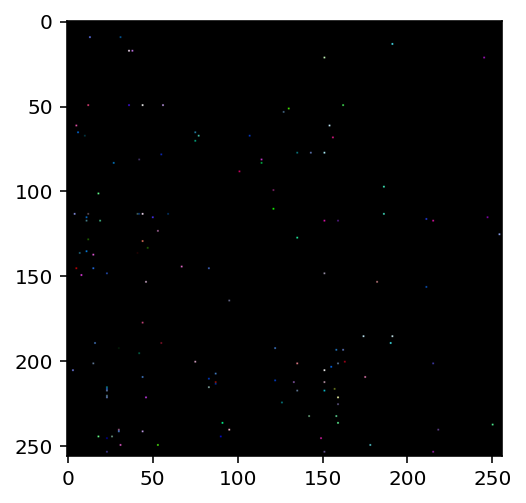

ang


In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image

import matplotlib.pyplot as plt
import torchvision.transforms as transforms


indecies = np.where(t)[0]

cnt = 0

for i in indecies:
  # wandb.log({"fakge": [wandb.Image(i.reshape([256, 256, 3]), mode="RGB") for i in test_set[i][0]]})
  tf = T.ToPILImage()
  img_t = tf(raw_test_set[i][0])
  plt.imshow(img_t)
  plt.show()
  print('ang')
  
  cnt += 1
  if cnt > 20 :
    break


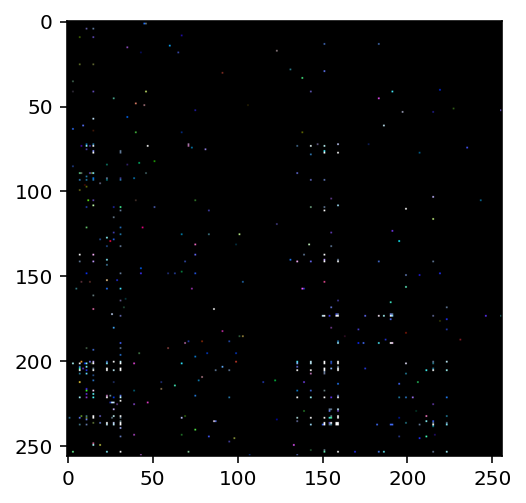

ang


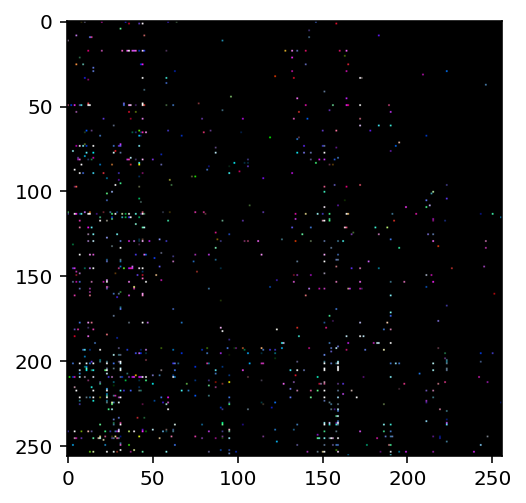

ang


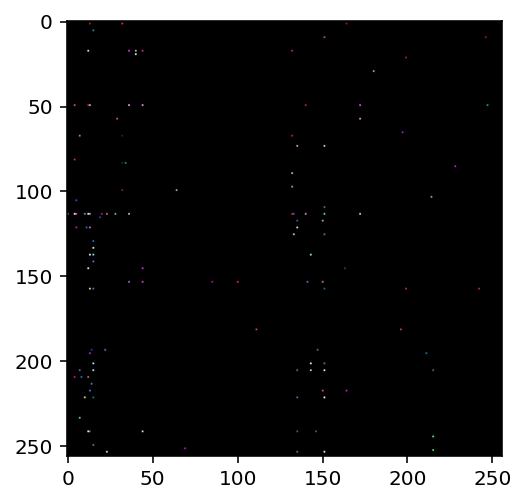

ang


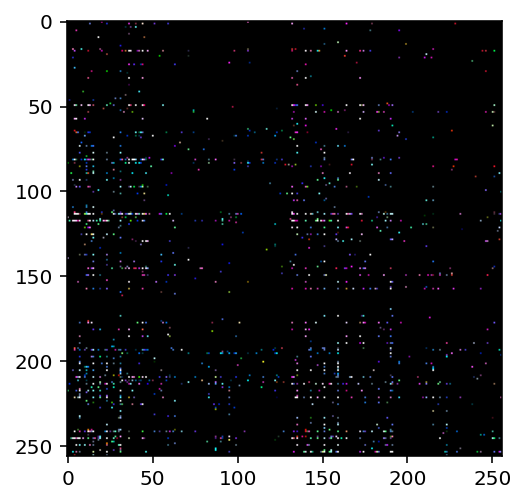

ang


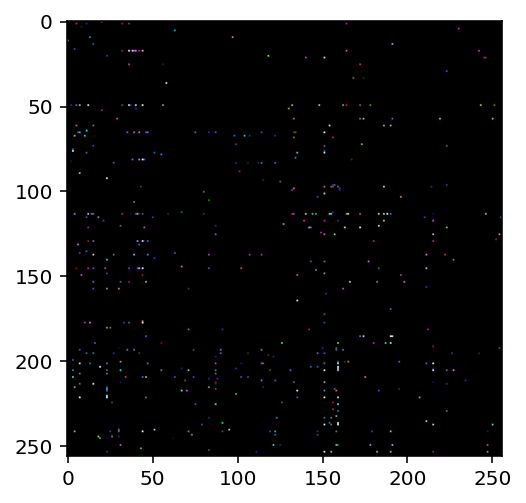

ang


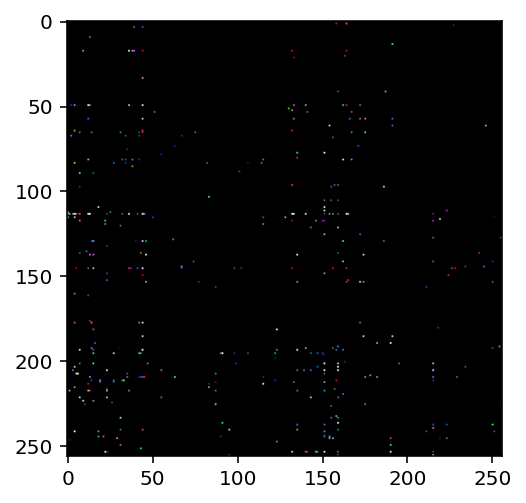

ang


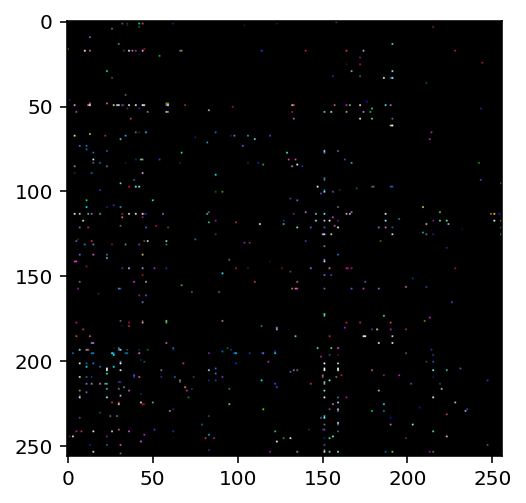

ang


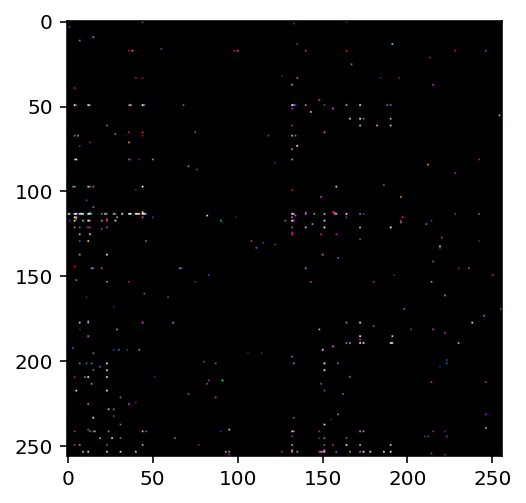

ang


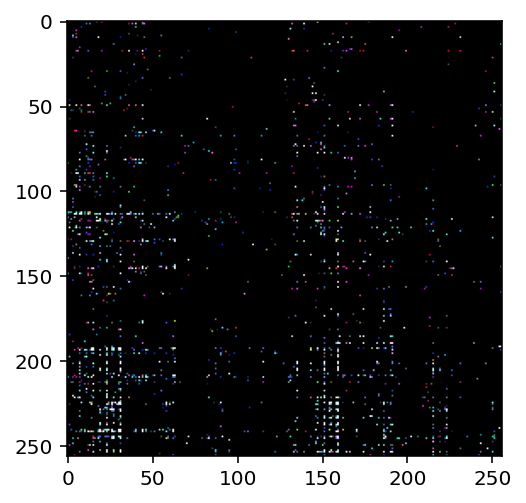

ang


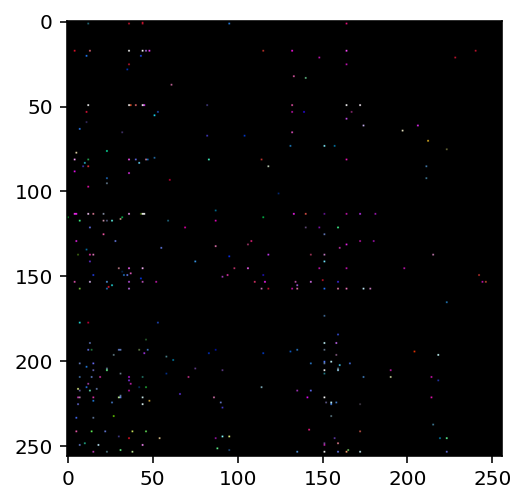

ang


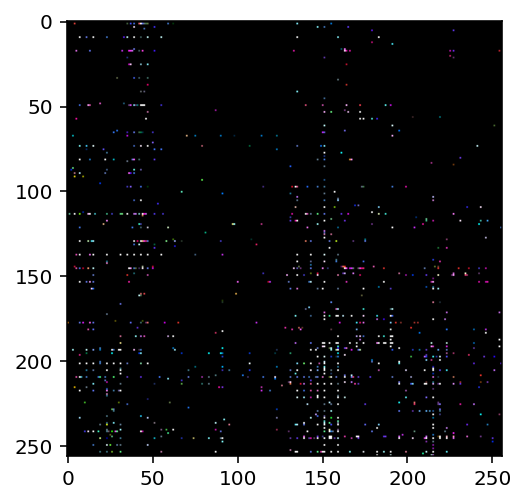

ang


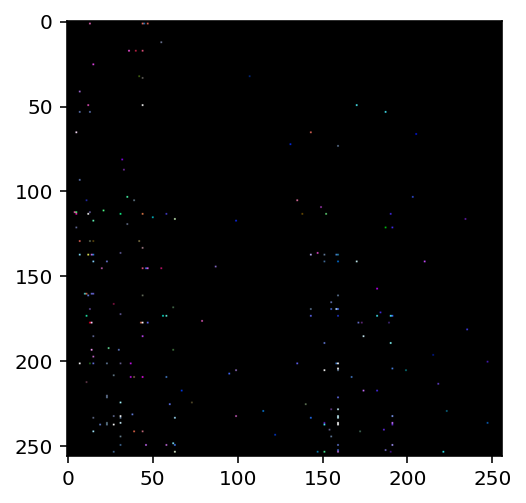

ang


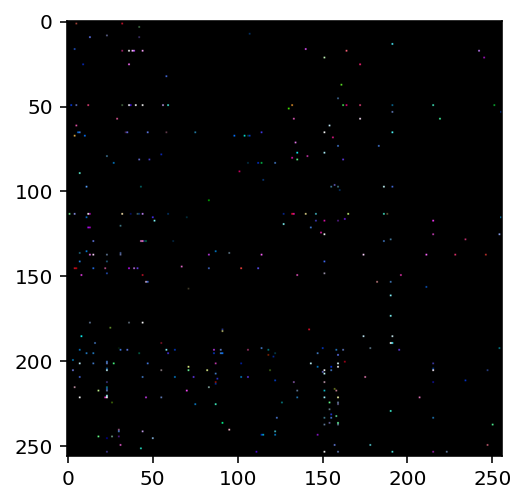

ang


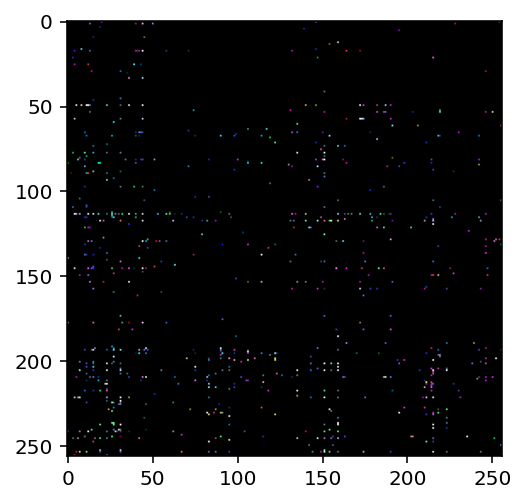

ang


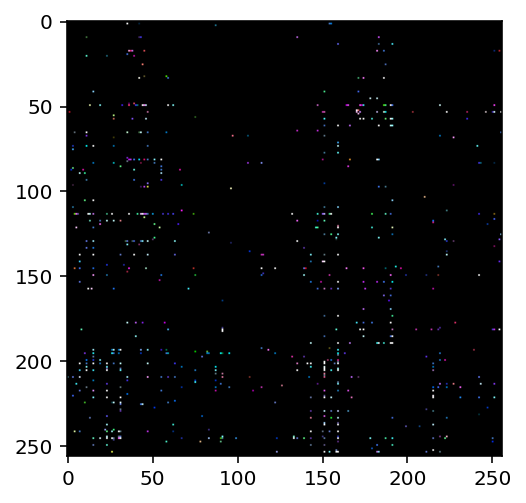

ang


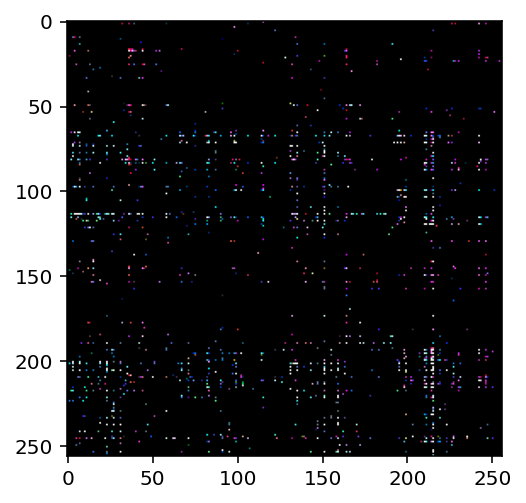

ang


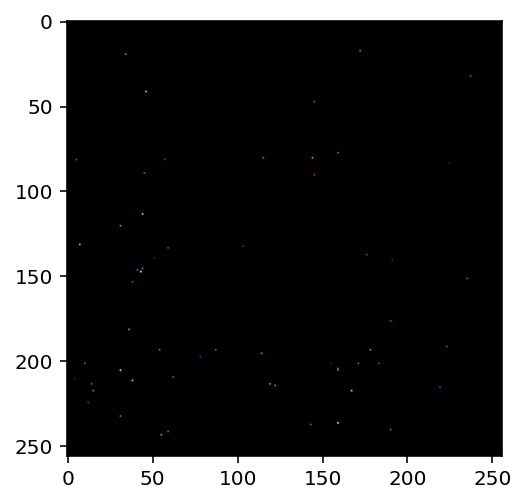

ang


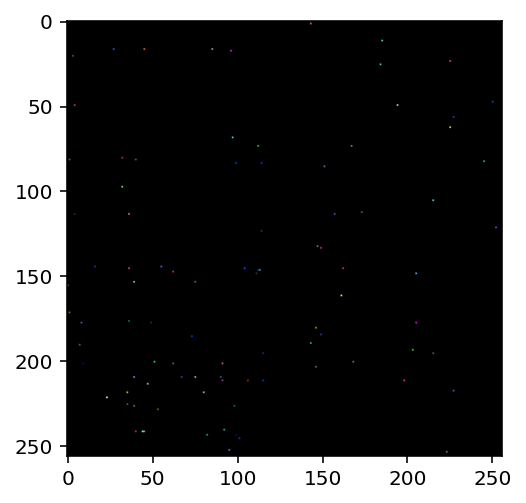

ang


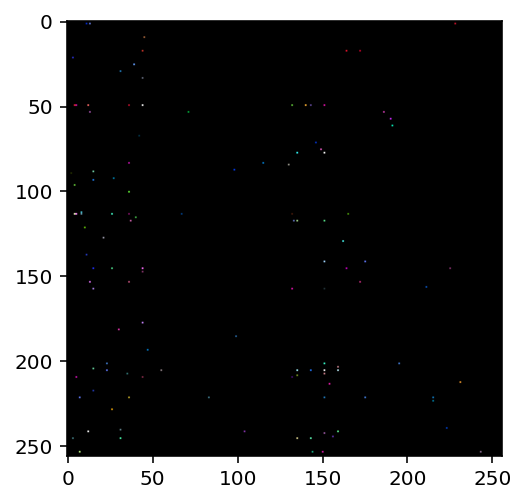

ang


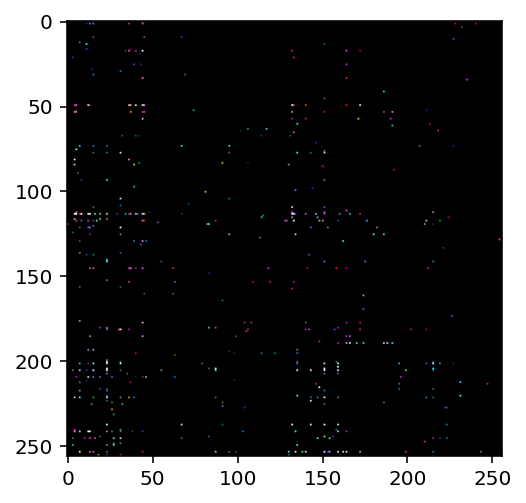

ang


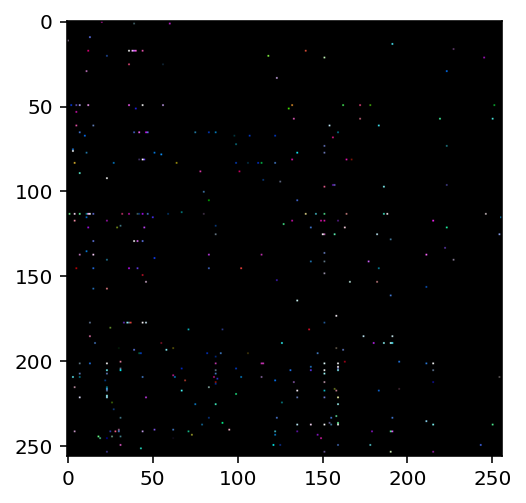

ang


In [ ]:
indecies = np.where(f)[0]

cnt = 0

for i in indecies:
  # wandb.log({"fakge": [wandb.Image(i.reshape([256, 256, 3]), mode="RGB") for i in test_set[i][0]]})
  tf = T.ToPILImage()
  img_t = tf(raw_test_set[i][0])
  plt.imshow(img_t)
  plt.show()
  print('ang')
  
  cnt += 1
  if cnt > 20 :
    break
